In [1]:
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import logging
import pptk as pptker

In [2]:
file = "unnamed123.jpg"

In [3]:
colourImg = Image.open(file)
colourPixels = colourImg.convert("RGB")
colourArray = np.array(colourPixels.getdata()).reshape(colourImg.size + (3,))
indicesArray = np.moveaxis(np.indices(colourImg.size), 0, 2)
allArray = np.dstack((indicesArray, colourArray)).reshape((-1, 5))

df = pd.DataFrame(allArray, columns=["y", "x", "red","green","blue"])

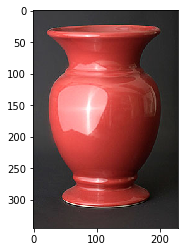

238050

In [4]:
img = matplotlib.image.imread(file)
imgplot = plt.imshow(img)
plt.show()
img.size

In [ ]:
v = pptker.viewer(df[['red', 'green', 'blue']], df[['red', 'green', 'blue']]/255.)
v.set(point_size=0.3)

In [ ]:
import torch
import itertools

class ComplexKmeans:
    """K-Means surface clustering.
    Parameters
    ----------
    n_clusters : int, default=2
        The number of clusters to form as well as the number of
        centroids to generate.

    max_iter : int, default=300
        Maximum number of iterations of the k-means algorithm for a
        single run.

    Attributes
    ----------
    cluster_centers_ : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster centers. If the algorithm stops before fully
        converging (see ``tol`` and ``max_iter``), these will not be
        consistent with ``labels_``.
    labels_ : ndarray of shape (n_samples,)
        Labels of each point
    inertia_ : float
        Sum of squared distances of samples to their closest cluster center.
    n_iter_ : int
        Number of iterations run.

    """
    def __init__(self, n_clusters=1, n_lines=2, max_iter=2, n_init=2):
        self.n_clusters = n_clusters
        self.n_lines = n_lines
        self.max_plane_iter = max_iter
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = 10
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger('spam')
        self.cluster_labeler = []
        print(self.n_clusters)  
    
    def _get_cluster_labels_gpu(self, X_gpu, planes, centroids, outliers=0):               
        d = -np.sum(planes*centroids, axis = 1)
        planes4d = np.c_[planes, d]       
        planes4d_gpu = torch.from_numpy(planes4d).float().to("cuda:0")
        distance = (torch.div(torch.matmul(X_gpu, planes4d_gpu.unsqueeze(2)), torch.norm(planes4d_gpu, p=2, dim=1)))[:,:,0]
        return torch.argmax(-torch.abs(distance), dim=0)
    
    def _get_cluster_labels_line_gpu(self, X_gpu, planes, centroids, outliers=0):
        lines4d_gpu = torch.from_numpy(planes).float().to("cuda:0")
        centroids_gpu = torch.from_numpy(centroids).float().to("cuda:0")
        distance = torch.zeros((len(centroids), X_gpu.shape[0]))
        for i in range(len(centroids)):
            verctors4d_gpu = - X_gpu[:,:-1] + centroids_gpu[i]
            temp = torch.cross(verctors4d_gpu, torch.cat(X_gpu.shape[0]*[lines4d_gpu[i].unsqueeze(0)]), dim=1)
            numerator = torch.norm(temp, p=2, dim=1)
            denominator = torch.norm(lines4d_gpu[i])
            distance[i] = numerator/denominator
        return torch.argmax(-torch.abs(distance), dim=0)
                

    def fit(self, X):
        """Compute k-means clustering.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.
        Returns
        -------
        self
            Fitted estimator.
        """
        best_centroids = None
        best_plane = None
        best_variance = None
        best_pca = [np.zeros(0) for i in range(self.n_clusters)]

        for i in range(self.n_init):
            k = self.n_clusters # - i + 1
            if k < 1:
                k = 1
            # Initialize centers
            planes = self._init_planes(k)
            centroids = self._init_centroids(k)      
            
            variance = np.zeros(k)
            pca_clusters = [np.zeros(0) for i in range(self.n_clusters)]
            
            X4d = np.c_[X, np.ones(X.shape[0])]
            X_gpu = torch.cat(1*[torch.from_numpy(X4d).float()]).to("cuda:0")

            for iteration in range(0, self.max_plane_iter):
                colours = self._get_cluster_labels_gpu(X_gpu, planes, centroids).cpu()
                for num_cluster in range(0, k):
                    pca = PCA(n_components=3)
                    data_cluster = np.array(X)[colours == num_cluster]
                    if (len(data_cluster) > 10):
                        pca.fit(data_cluster)
                        planes[num_cluster] = pca.components_[-1]
                        centroids[num_cluster] = pca.mean_
                        variance[num_cluster] = pca.explained_variance_[-1]
                        pca_clusters[num_cluster] = pca.components_
                    else:
                        planes[num_cluster] = planes[0]
                        + np.random.rand(3)*1
                        print("Lose")
                        # centroids[num_cluster] = centroids[num_cluster-1]
                        # + np.random.rand(3)*10
                        # print(planes[num_cluster])
                        # print(centroids[num_cluster])
                    logging.debug(f'Iteration: {iteration}')
                    logging.debug(f'Centroid {num_cluster}: {centroids[num_cluster]}')
                    logging.debug(f'Plane {num_cluster}: {planes[num_cluster]}')
                logging.debug(f'Variance: {np.sum(variance)}')

                if (best_variance is None or np.sum(variance) < best_variance):
                    best_variance = np.sum(variance)
                    best_plane = planes.copy()
                    best_centroids = centroids.copy()
                    best_pca = pca_clusters.copy()

        
        result_colours = self._get_cluster_labels_gpu(X_gpu, best_plane, best_centroids).cpu().numpy()
        self.cluster_labeler = [[i] for i in range(len(best_plane))]
        
        array_lines = [np.zeros(0) for i in range(len(best_plane))]
        array_centroids = [np.zeros(0) for i in range(len(best_plane))]

        plane_clusters = set(result_colours) 
        
        if self.n_lines <= 0:
             return [result_colours, best_plane, best_centroids, array_lines, array_centroids]
        
        for cluster in range(0, len(best_plane)):
            if cluster not in plane_clusters:
                continue
            if len(best_pca[cluster]) is 0:
                continue
            Y = X_gpu[result_colours == cluster]
            [colours, new_lines, new_line_centroids] = self._fit_lines(Y, best_plane[cluster])
         
            temp_colours = colours.cpu().numpy()
            self.cluster_labeler[cluster].extend(max(*self.cluster_labeler) + np.array(range(1, len(new_lines+1))))
            
            # update colours for lines in plane 
            merged = list(itertools.chain(*self.cluster_labeler))
            result_colours[result_colours == cluster] = max(merged) +colours.cpu().numpy() + 1
           
            # save best lines
            array_lines[cluster] = new_lines
            array_centroids[cluster] = new_line_centroids

        return [result_colours, best_plane, best_centroids, array_lines, array_centroids]
    
    def _fit_lines(self, X_gpu, plane):
        best_centroids = None
        best_lines = None
        best_variance = None
        
        for i in range(self.n_init):
            k = self.n_lines - i + 1
            if k <= 1:
                k = 2
            lines = self._init_lines_at_planes(k, plane)
            centroids = self._init_centroids(k)
            variance = np.zeros(k)
            ratio_variance = np.zeros(k)
            
            iteration = 0
            iteration_timeout = 0
            while iteration <= self.max_iter:
                iteration += 1
                colours = self._get_cluster_labels_line_gpu(X_gpu, lines, centroids)
                for num_cluster in range(0, k):
                    pca = PCA(n_components=3)
                    data_cluster = X_gpu[colours==num_cluster][:, :-1].cpu()
                    if (len(data_cluster) > 2):
                        pca.fit(data_cluster)
                        lines[num_cluster] = pca.components_[0]
                        centroids[num_cluster] = pca.mean_
                        variance[num_cluster] = pca.explained_variance_[-1] + pca.explained_variance_[-2]
                        ratio_variance[num_cluster] = pca.explained_variance_ratio_[-1] + pca.explained_variance_ratio_[-2]
                        logging.debug(f'Variance ratio: {pca.explained_variance_ratio_}')
                    else:
                        vec = np.random.rand(3)
                        #lines[num_cluster] = vec-vec*plane
                        lines[num_cluster] = self._init_lines_at_planes(1, plane)
                        #centroids[num_cluster] = centroids[num_cluster-1]# + np.random.rand(3)*3
                        print(lines[num_cluster])
                        print(centroids[num_cluster])
                        print("Lose")
                        iteration = 1
                        iteration_timeout += 1
                        if iteration_timeout > 4:
                            iteration = self.max_iter + 1
                    logging.debug(f'Iteration: {iteration}')
                    logging.debug(f'Centroid {num_cluster}: {centroids[num_cluster]}')
                    logging.debug(f'Line {num_cluster}: {lines[num_cluster]}')
                logging.debug(f'Variance: {np.sum(variance)}')
                logging.debug(f'Variance ratio: {np.sum(ratio_variance)}')
                
                if (best_variance is None or np.sum(variance) < best_variance):
                    best_variance = np.sum(variance)
                    best_lines = lines.copy()
                    best_centroids = centroids.copy()
                    
                if (np.sum(variance) < 31):
                    break

        colours = self._get_cluster_labels_line_gpu(X_gpu, best_lines, best_centroids)
        return [colours, best_lines, best_centroids]


    def _init_centroids(self, k: int):
        centroids = []
        for i in range(k):
            centroids.append(np.random.rand(3)*255)
        return np.array(centroids)

    def _init_centroids_2d(self, k: int):
        centroids = []
        for i in range(k):
            centroids.append(np.random.rand(2)*255)
        return np.array(centroids)

    def _init_lines(self, k: int):
        lines = []
        for i in range(k):
            lines.append(np.random.rand(2)*10)
        return np.array(lines)
    
    def _init_lines_at_planes(self, k: int, plane):
        planes = []
        for i in range(k):
            vec = np.random.rand(3)
            planes.append(vec-np.dot(vec, plane))
        return np.array(planes)
        
    def _init_planes(self, k: int):
        planes = []
        for i in range(k):
            planes.append(np.random.rand(3)*10)
        return np.array(planes)


In [ ]:
def distcreate_data(df):
    step = 64
    Y = np.empty((1, 4))
    X = df[['red', 'green', 'blue']]
    for i in range(0, 256, step):
        for j in range(0, 256, step):
            for k in range(0, 256, step):
                temp = X.loc[X['red'].between(i, i+step) & X['green'].between(j, j+step) & X['blue'].between(k, k+step)]
                lens = len(temp)
                if (lens > 0):
                    temp['temp'] = np.zeros(lens)
                    mean_temp = temp.groupby('temp')['red', 'green', 'blue'].mean()
                    mean_temp['mass'] = lens
                    Y = np.append(Y, mean_temp[['red', 'green', 'blue', 'mass']].to_numpy(), axis=0)
    return Y

Y = distcreate_data(df)

t = Y[:,-1]/255.
v = pptk.viewer(Y[:,:-1], t)
v.set(point_size=2)

In [ ]:
X = df[['red', 'green', 'blue']].to_numpy()

#X = Y[:,:-1]
kmean_test = ComplexKmeans(n_clusters=1, n_lines=2, max_iter=6, n_init=3)

[colours, new_planes, new_centroids, array_lines, array_centroids] = kmean_test.fit(X)

#cluster_label = kmean_test._get_cluster_labels(df[['red', 'green', 'blue']].to_numpy(), array_lines[0], array_centroids[0], kmean_test._line_distance)
#colours = np.array(cluster_label)[:, 0]
print(new_planes)
print(new_centroids)


In [ ]:
colours

In [ ]:
set_colours = set(colours)
df["kmeans"] = colours

In [ ]:
set_colours 

Draw final RGB

In [15]:
import numpy as np
import pptk

import importlib
importlib.reload(pptk)

<module 'pptk' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\pptk\\__init__.py'>

In [16]:
from importlib import reload  

pptk = reload(pptk)

In [ ]:
import numpy as np
import pptk

import importlib
importlib.reload(pptk)

mean_df = df.groupby('kmeans')['red', 'green', 'blue'].mean()

for cluster in set_colours:
    print("1")
    try:
        df.loc[df['kmeans'] == cluster, 'red_cluster'] = mean_df.loc[cluster][0]
        df.loc[df['kmeans'] == cluster, 'green_cluster'] = mean_df.loc[cluster][1]
        df.loc[df['kmeans'] == cluster, 'blue_cluster'] = mean_df.loc[cluster][2]
    except:
        logging.warning(f'Cluster {cluster} is empty')
        continue
        
print(df[['red', 'green', 'blue']])

print(df[['red_cluster', 'green_cluster', 'blue_cluster']]/255.)

print(len(df[['red', 'green', 'blue']]))
        
v = pptk.viewer(df[['red', 'green', 'blue']], df[['red_cluster', 'green_cluster', 'blue_cluster']]/255.)

v.set(point_size=0.3)

1
1
1
       red  green  blue
0       64     63    68
1       64     63    68
2       64     63    68
3       64     63    68
4       63     62    67
...    ...    ...   ...
79345   46     46    44
79346   42     42    40
79347   43     43    41
79348   42     42    40
79349   39     39    37

[79350 rows x 3 columns]
       red_cluster  green_cluster  blue_cluster
0         0.242033       0.232796      0.236521
1         0.242033       0.232796      0.236521
2         0.242033       0.232796      0.236521
3         0.242033       0.232796      0.236521
4         0.242033       0.232796      0.236521
...            ...            ...           ...
79345     0.242033       0.232796      0.236521
79346     0.242033       0.232796      0.236521
79347     0.242033       0.232796      0.236521
79348     0.242033       0.232796      0.236521
79349     0.242033       0.232796      0.236521

[79350 rows x 3 columns]
79350


In [6]:
import numpy as np
import pptk

import importlib
importlib.reload(pptk)


x = np.random.rand(100, 3)
pptk.viewer(x)

Рисуем данные и нормали к найденным плоскостям(Для дебага)

In [ ]:
t = np.linspace(-255, 255, 1000)
axes = np.array([t,t,t])

line1 = np.array([new_planes*axes[:,i]+new_centroids for i in range(1000)])
line2 = np.array([array_lines[0]*axes[:,i]+array_centroids[0] for i in range(1000)])
A = np.vstack((df[['red', 'green', 'blue']], *line2[:,])) #,line1[:,1]
#A = np.vstack((Y, *line2[:,])) #,line1[:,1]

v = pptk.viewer(A)

In [35]:
def generate_picture(df):
    mean_df = df.groupby('kmeans')['red', 'green', 'blue'].mean()

    for cluster in set_colours:
        try:
            df.loc[df['kmeans'] == cluster, 'red_cluster'] = mean_df.loc[cluster][0]
            df.loc[df['kmeans'] == cluster, 'green_cluster'] = mean_df.loc[cluster][1]
            df.loc[df['kmeans'] == cluster, 'blue_cluster'] = mean_df.loc[cluster][2]
        except:
            logging.warning(f'Cluster {cluster} is empty')
            continue
    test = (df[['red_cluster','green_cluster', 'blue_cluster']]/ 255.).to_numpy().reshape(img.shape[0:2] + (3, ))
    imgplot = plt.imshow(test)
    plt.show()

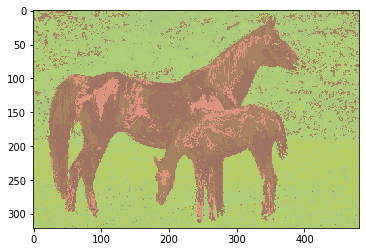

In [36]:
generate_picture(df)

In [ ]:
for cluster in set_colours:
    df_cluster = df.copy()
    df_cluster.loc[df['kmeans'] != cluster, 'red'] = 255
    df_cluster.loc[df['kmeans'] != cluster, 'green'] = 255
    df_cluster.loc[df['kmeans'] != cluster, 'blue'] = 255
    test = (df_cluster[['red','green', 'blue']]/ 255.).to_numpy().reshape(img.shape[0:2] + (3, ))
    imgplot = plt.imshow(test)
    #plt.figure(figsize=(7,7))
    plt.show()
    

In [ ]:
import torch
import numpy as np


X = np.array([[0, 1, 2, 1], [1, 4, 2, 1], [1, 2 ,3 ,1]])

planes4d = np.array([[1, 1, 0, 0]])

X_gpu = torch.cat(1*[torch.from_numpy(X).float()]).to("cuda:0")

planes4d_gpu = torch.from_numpy(planes4d).float().to("cuda:0")

print(planes4d_gpu)
print(X_gpu)

#rint(torch.norm(planes4d_gpu, p=2, dim=1))
print(torch.div(torch.matmul(X_gpu, planes4d_gpu.unsqueeze(2)), torch.norm(planes4d_gpu, p=2, dim=1))[:,:,0])


def _get_cluster_labels_gpu(X, planes, centroids, outliers=0):
        label = []
        cluster_label = []
        X4d = np.c_[X, np.ones(X.shape[0])]
        X_gpu = torch.cat(1*[torch.from_numpy(X4d).float()]).to("cuda:0")
        
        d = -np.sum(plane*centroid, axis = 1)
        planes4d = np.c_[plane, d]
        
        planes4d_gpu = torch.from_numpy(planes4d).float().to("cuda:0")
  
        distance = (torch.div(torch.matmul(X_gpu, planes4d_gpu.unsqueeze(2)), torch.norm(planes4d_gpu, p=2, dim=1)))[:,:,0]            
        return torch.argmax(-torch.abs(distance), dim=0)

In [ ]:
plane = np.array([[0, 0, 1], [1, 1, 0]])
centroid = np.array([[1 ,1 ,1], [0, 1, 0]])
X = np.array([[0, 2, 1], [3, 1, 0], [1, 1, 1]])

temp = _get_cluster_labels_gpu(X, plane, centroid)
print(temp)

In [ ]:
plane = np.array([[0, 0, 1], [0, 1, 0]])
centroid = np.array([[1 ,1 ,1], [0, 1, 0]])

d = -np.sum(plane*centroid, axis = 1)
print(d)

planes4d = np.c_[ plane, d ] 

In [ ]:
planes4d

In [ ]:
plane*centroid

In [15]:
X = np.array([[0, 2, 3], [1, 2, 3], [4, 2 ,3]])

planes = np.array([[2, 1, 2], [2, 1, 2]])
centroids = np.array([[3, 1, -1], [3, 1, -1]])


X4d = np.c_[X, np.ones(X.shape[0])]
X_gpu = torch.cat(1*[torch.from_numpy(X4d).float()]).to("cuda:0")
lines4d_gpu = torch.from_numpy(planes).float().to("cuda:0")
centroids_gpu = torch.from_numpy(centroids).float().to("cuda:0")

print(X_gpu[:,:-1])

distance = torch.zeros((len(centroids), X.shape[0]))
for i in range(len(centroids)):
    verctors4d_gpu = - X_gpu[:,:-1] + centroids_gpu[i]
    #verctors4d_gpu = torch.from_numpy(vector).float().to("cuda:0")
    temp = torch.cross(verctors4d_gpu, torch.cat(X.shape[0]*[lines4d_gpu[i].unsqueeze(0)]), dim=1)
    numerator = torch.norm(temp, p=2, dim=1)
    denominator = torch.norm(lines4d_gpu[i])
    #print(numerator/denominator)
    distance[i] = numerator/denominator

print(torch.argmax(-torch.abs(distance), dim=0))

#vector = point - centroid
#mul = np.cross(vector, line)
#return np.sqrt(np.sum(mul**2)/np.sum(line**2))

tensor([[0., 2., 3.],
        [1., 2., 3.],
        [4., 2., 3.]], device='cuda:0')
tensor([1, 1, 1])


In [ ]:
X = np.array([[0, 0, 3], [3, 0, 0], [0, 3 ,0], [0, 0, 0]])

planes = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
centroids = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])


X4d = np.c_[X, np.ones(X.shape[0])]
X_gpu = torch.cat(1*[torch.from_numpy(X4d).float()]).to("cuda:0")

def _get_cluster_labels_line_gpu(X_gpu, planes, centroids, outliers=0):
        lines4d_gpu = torch.from_numpy(planes).float().to("cuda:0")
        centroids_gpu = torch.from_numpy(centroids).float().to("cuda:0")

        distance = torch.zeros((len(centroids), X.shape[0]))
        for i in range(len(centroids)):
            verctors4d_gpu = - X_gpu[:,:-1] + centroids_gpu[i]
            temp = torch.cross(verctors4d_gpu, torch.cat(X.shape[0]*[lines4d_gpu[i].unsqueeze(0)]), dim=1)
            numerator = torch.norm(temp, p=2, dim=1)
            denominator = torch.norm(lines4d_gpu[i])
            distance[i] = numerator/denominator
        print(distance)
        return torch.argmax(-torch.abs(distance), dim=0)
    
_get_cluster_labels_line_gpu(X_gpu, planes, centroids)

In [118]:
x = {}

In [110]:
x

[[], []]

In [31]:
x = [[i] for i in range(2)]

In [32]:
x

[[0], [1]]

In [33]:
max(x)

[1]

In [36]:
x[0].extend(max(*x) + np.array(range(1, 3)))

In [37]:
x

[[0, 2, 3], [1]]

In [38]:
1 + list(range(1, 3))

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [49]:
[i for i in x]

[[0, 2, 3], [1]]

In [50]:
import itertools
merged = list(itertools.chain(*x))

In [51]:
merged

[0, 2, 3, 1]